#### This notebook demonstrates the use of a reweighing pre-processing algorithm for bias mitigation


In [1]:
%matplotlib inline

# Load all necessary packages
import sys
sys.path.insert(1, "../")

import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

from common_utils import compute_metrics

c:\Users\matej\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\_functorch\deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


#### Load dataset and set options

In [2]:
## import dataset
dataset_used = "adult" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2


if dataset_used == "adult":
#     dataset_orig = AdultDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_adult(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_adult(['race'])
    
elif dataset_used == "german":
#     dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_german(['sex'])
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        dataset_orig = load_preproc_data_german(['age'])
    
elif dataset_used == "compas":
#     dataset_orig = CompasDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_compas(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_compas(['race'])

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]

#random seed for calibrated equal odds prediction
np.random.seed(1)
(df, md) = dataset_orig.convert_to_dataframe()
df

..\aif360\algorithms\preprocessing\optim_preproc_helpers\data_preproc_functions.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['sex'].replace({'Female': 0.0, 'Male': 1.0})


,race,sex,Age (decade)=10,Age (decade)=20,Age (decade)=30,Age (decade)=40,Age (decade)=50,Age (decade)=60,Age (decade)=>=70,Education Years=6,Education Years=7,Education Years=8,Education Years=9,Education Years=10,Education Years=11,Education Years=12,Education Years=<6,Education Years=>12,Income Binary
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
48838,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
48839,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
48840,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Split into train, and test

In [3]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

#### Clean up training data

In [4]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


#### Metric for original training data

In [5]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.190244


#### Train with and transform the original training data

In [6]:
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [7]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

#### Metric with the transformed training data

In [8]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [9]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < 1e-6

### Train classifier on original data

In [10]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()

lmod.fit(X_train, y_train, w_train)

#prediction on the same set it was trained on
y_train_pred = lmod.predict(X_train)

# positive class index
# lmod can maybe switch indexes of positive and negative clases, so we need to get index of our favorable class in our trainde model
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

# for predicted training set we use same training data, but give it labels, prduced by trained model on same dataset 
dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores for original validation and test sets

In [11]:
# we will then change only the labels/predictions/y values, x values stay the same
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)

# we scale validation set in same way as we did train set
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)

# we get true labels from validation set
y_valid = dataset_orig_valid_pred.labels

#we get probabilities that something has a true label of the class
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)


dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
#we use same transform as before
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

# training set was reweighted, which in theory tells us that discrimination is smaller
# now we have -> train set - true and pred labels, validation/test set - true labels, predicted scores

### Find the optimal classification threshold from the validation set

In [12]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh

    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    # we calculate balanced accuracy
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate() + classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.7463
Optimal classification threshold (no reweighing) = 0.2872


### Predictions from the original test set at the optimal classification threshold

In [13]:
# we would like to test balanced accuracy on test set, but save also balanced accuracies of other thresholds

display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.2872


 45%|████▌     | 45/100 [00:00<00:00, 118.29it/s]

Balanced accuracy = 0.7437
Statistical parity difference = -0.3580
Disparate impact = 0.2794
Average odds difference = -0.3181
Equal opportunity difference = -0.3769
Theil index = 0.1129


 69%|██████▉   | 69/100 [00:00<00:00, 103.15it/s]..\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|██████████| 100/100 [00:00<00:00, 102.60it/s]


#### Display results for all thresholds

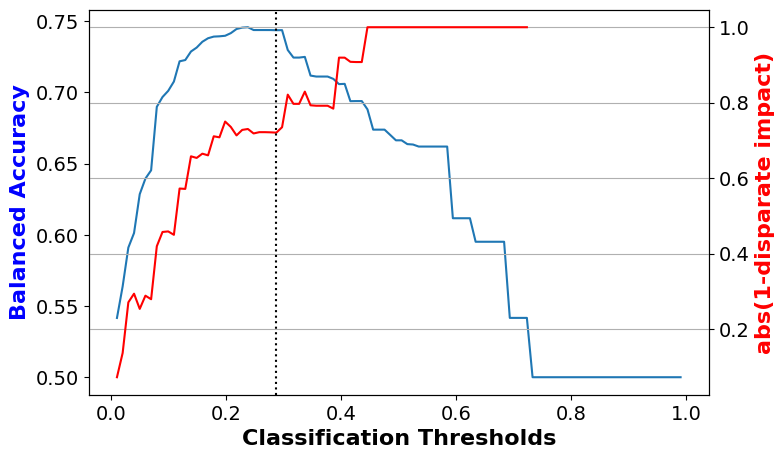

In [14]:
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

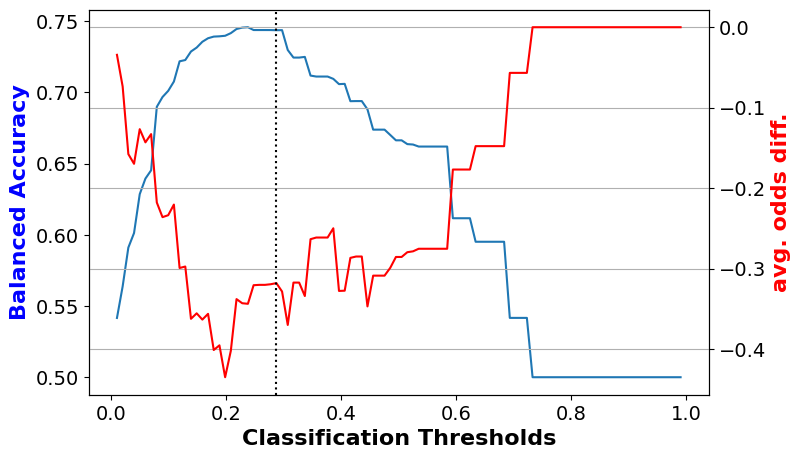

In [15]:
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` must be close to zero for the classifier to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

### Train classifier on transformed data

In [16]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

#### Obtain scores for transformed test set

In [17]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Predictions from the transformed test set at the optimal classification threshold

In [18]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.2872


 48%|████▊     | 48/100 [00:00<00:00, 127.18it/s]

Balanced accuracy = 0.7134
Statistical parity difference = -0.0705
Disparate impact = 0.7785
Average odds difference = 0.0188
Equal opportunity difference = 0.0293
Theil index = 0.1401


 65%|██████▌   | 65/100 [00:00<00:00, 140.22it/s]..\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|██████████| 100/100 [00:00<00:00, 133.99it/s]


#### Display results for all thresholds

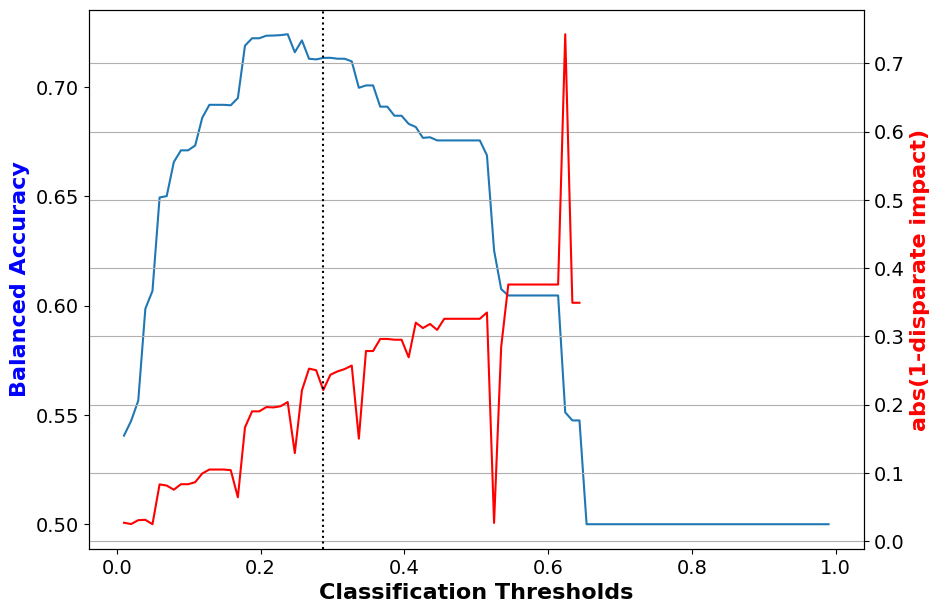

In [19]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case.
This implies fairness.

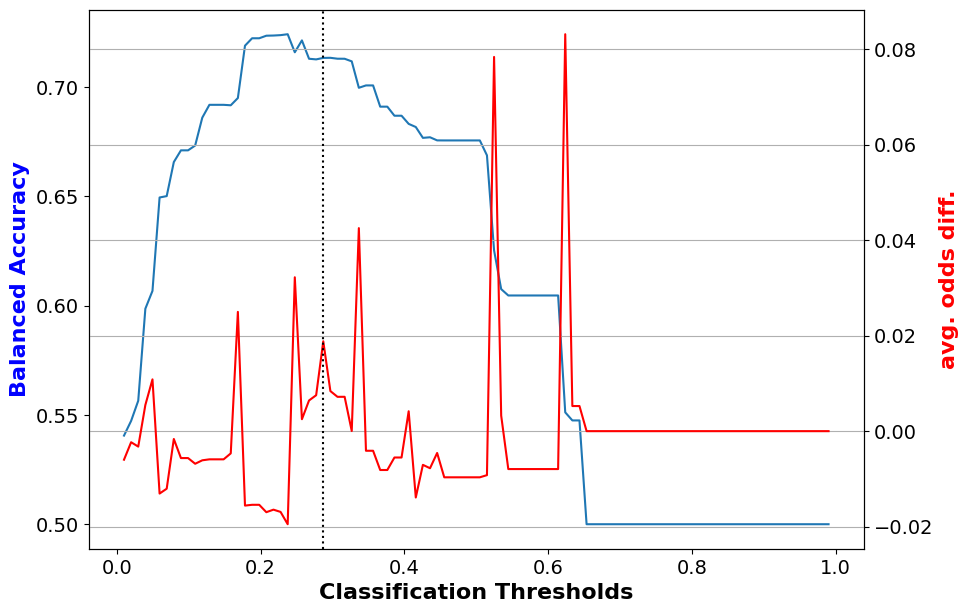

In [20]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` must be close to zero for the classifier to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case.
This implies fairness.

# Summary of Results
We show the optimal classification thresholds, and the fairness and accuracy metrics.

### Classification Thresholds

| Dataset |Classification threshold|
|-|-|
|Adult||0.2674|
|German|0.6732|
|Compas|0.5148|

### Fairness Metric: Disparate impact, Accuracy Metric: Balanced accuracy

#### Performance

| Dataset |Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|Race/Age (Acc-Bef)|Race/Age (Acc-Aft)|Race/Age (Fair-Bef)|Race/Age (Fair-Aft)|
|-|-|-|-|-|-|-|-|-|
|Adult (Test)|0.7417|0.7128|0.2774|0.7625|0.7417|0.7443|0.4423|0.7430|
|German (Test)|0.6524|0.6460|0.9948|1.0852|0.6524|0.6460|0.3824|0.5735|
|Compas (Test)|0.6774|0.6562|0.6631|0.8342|0.6774|0.6342|0.6600|1.1062|



### Fairness Metric: Average odds difference, Accuracy Metric: Balanced accuracy

#### Performance

| Dataset |Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|Race/Age (Acc-Bef)|Race/Age (Acc-Aft)|Race/Age (Fair-Bef)|Race/Age (Fair-Aft)|
|-|-|-|-|-|-|-|-|-|
|Adult (Test)|0.7417|0.7128|-0.3281|-0.0266|0.7417|0.7443|-0.1991|-0.0395|
|German (Test)|0.6524|0.6460|0.0071|0.0550|0.6524|0.6460|-0.3278|-0.1944|
|Compas (Test)|0.6774|0.6562|-0.2439|-0.0946|0.6774|0.6342|-0.1927|0.1042|